# Cora citation network

In [1]:
import networkx as nx
import numpy as np
import pickle as p
from matplotlib import pyplot as plt
%matplotlib inline

data_loc = './../data/raw/cora/'  # 'cora.cites', 'cora.content'

Cora is a directed citation network of 2708 papers with link as citation (citing paper points to cited paper, the order in the edgelist is reversed). Each paper has one label (7 types of label in total). The labels are:

- Case Based
- Genetic Algorithms
- Neural Networks
- Probabilistic Methods
- Reinforcement Learning
- Rule Learning
- Theory

Also, each papers has a binary feature vector of 1433 elements (word existance indicator) describing the content of the node. The end of each feature vector is the string label of the paper (e.g. Case_Based, or Neural_Networks). All nodes has label and feature vector.

## Load data from edge list

In [2]:
graph_file = open(data_loc+'cora.cites', 'r')

Print the first 5 lines of the graph file:

In [3]:
for _ in range(5): print(repr(graph_file.readline()))

'35\t1033\n'
'35\t103482\n'
'35\t103515\n'
'35\t1050679\n'
'35\t1103960\n'


In [4]:
graph_file.seek(0)
cora_edgelist = []
for line in graph_file.readlines():
    i, j = line.split()
    cora_edgelist.append((int(j),int(i)))  # Correct direction of links

In [5]:
print("Number of edges:", len(cora_edgelist))

Number of edges: 5429


In [6]:
cora = nx.DiGraph(cora_edgelist)

In [7]:
print("Number of nodes:", len(cora))

Number of nodes: 2708


I would like to have standard network data with nodes id ranging from 0 to 2707. 

In [8]:
# Get a conversion dictionary
lookup = {}
for new_ids, ids in enumerate(cora.nodes()):
    lookup[ids] = new_ids
# Create new graph with new node ids
new_cora = nx.DiGraph()
for i, j in cora.edges():
    new_cora.add_edge(lookup[i], lookup[j])

## Load labels and features

In [12]:
content = data_loc+'cora.content'
labels = {'Case_Based': 0, 'Genetic_Algorithms': 1, 'Neural_Networks': 2, 
          'Probabilistic_Methods': 3, 'Reinforcement_Learning':4, 
          'Rule_Learning': 5, 'Theory': 6}
cora_labels = np.ndarray(shape=len(new_cora), dtype=int)
cora_features = np.ndarray(shape=(len(new_cora), 1433), dtype=int)
with open(content, 'r') as f:
    for lines in f.readlines():
        idx, *data, label = lines.strip().split()
        idx = int(idx)
        cora_labels[lookup[idx]] = labels[label]
        for i, val in enumerate(map(int, data)):
            cora_features[lookup[idx]][i] = val

Sanity check on newly created data. This check assert that the sum of all features and the labels matches the newly converted indices. If the test passes, we have `cora_labels` and `cora_features` as two lists where indices of the list corresponse with node ids.

In [24]:
with open(content, 'r') as f:
    for lines in f.readlines():
        idx, *data, label = lines.strip().split()
        idx = int(idx)
        assert sum(cora_features[lookup[idx]]) == sum(map(int, data))
        assert cora_labels[lookup[idx]] == labels[label]
    print("Sanity test for cora_features and cora_labels passed.")

Sanity test for cora_features and cora_labels passed.


Convert feature matrix `cora_features` to sparse format and dump data as pickle file:

In [55]:
from scipy.sparse import csr_matrix
cora_csr_features = csr_matrix(cora_features)
cora_dataset = {'NXGraph': new_cora, 'Labels': cora_labels, 'CSRFeatures': cora_csr_features}
with open("./../data/cora.data", 'wb') as f:
    p.dump(cora_dataset, f, protocol=2)

## Visualize cora graph

In [39]:
import json
from networkx.readwrite import json_graph

# Dump JSON for D3 visualization (No class color - TODO)
json_data = json_graph.node_link_data(new_cora)
with open('./../data/cora_mono_graph.json', 'w') as f:
    json.dump(json_data, f)

I used Cytoscape to visualize cora network. In this visualization, the red color indicate high count of the most frequent network motif (4 nodes, 3 edges, 3 nodes point to 1).
```
0 0 0 0
1 0 0 0
1 0 0 0
1 0 0 0
```
The frequency of this motif is `964617`, Z-Score with 50 random graph is `-0.991014438`.

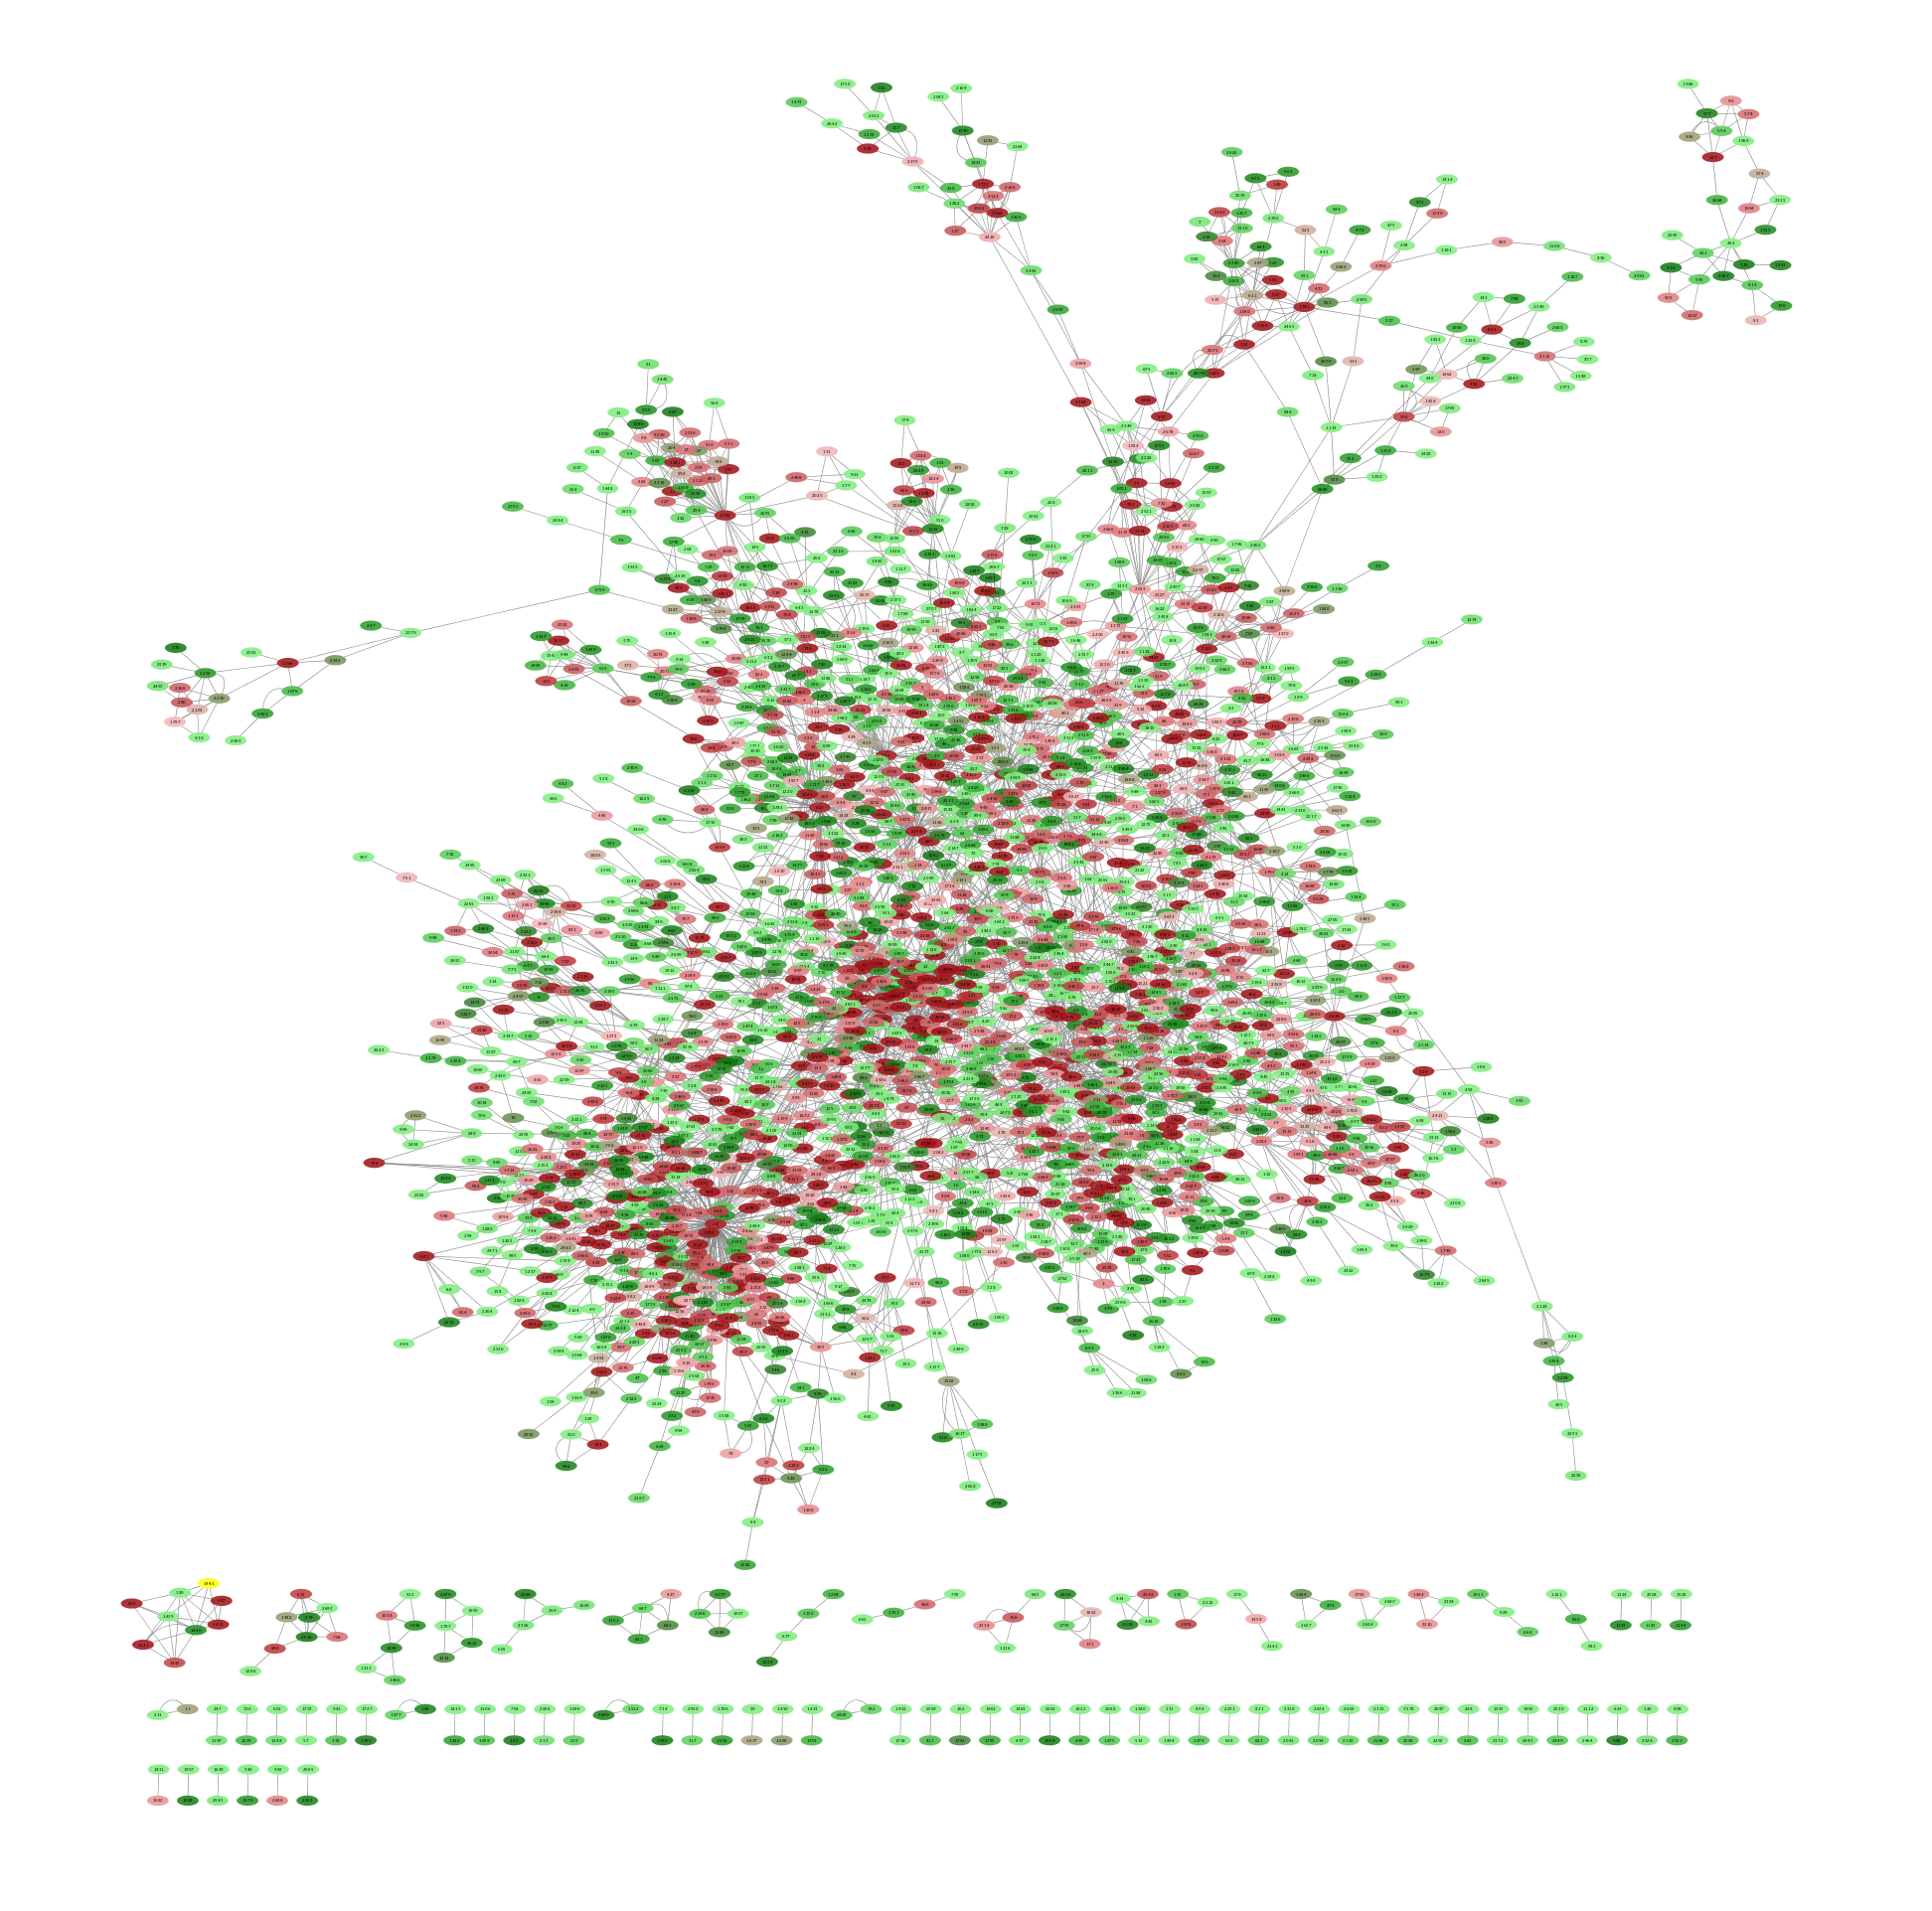

In [53]:
from IPython.display import Image

Image('../figs/cora_motif_highestfreq.png', width="1000px")

## Dump as edgelist

The graph (with new ids) will be written do disk as edgeslist to use with other algorithms.

In [48]:
nx.write_edgelist(new_cora, path='./../data/cora.edges')  # delimiter is a white space

## Network analysis

Since cora is a directed network, number of strongly and weakly connected components gives us some picture about the network macroscopic structure.

In [49]:
print("Number of strongly connected components: ", 
      nx.number_strongly_connected_components(new_cora))
print("Number of weakly connected components: ",
      nx.number_weakly_connected_components(new_cora))

Number of strongly connected components:  2526
Number of weakly connected components:  78
